# disable outliers

Given a set of 3d points and a set of joints:

$$
X_j = \big\{ x_a^j \big\}_a^{n_j}, \ \ x_a^j \in \mathbb{R}^3, \ \ 
j \in \mathcal{J}
$$
with
$$
\mathcal{J} =  \{1, .., J\}
$$

as well as a set of limbs:

$$
L = \big\{ (j,\hat{j})_l \big\}_l, \ \ \ j,\hat{j} \in \mathcal{J}
$$

define edges between joints of the same class as follows:

$$
E_j = \big\{ 
(x_a^j, x_b^j) : a \neq b \wedge 
\vert\vert x_a^j - x_b^j \vert\vert_2^2 < \delta
\big\}
$$

where $\delta$ is a distance threshold (in $mm$) after which no connection is considered anymore.
Furthermore, define edges over limbs as follows:

$$
E_l = \big\{ 
(x_a^j, x_b^{\hat{j}}) : j \neq \hat{j} \wedge
(j, \hat{j}) \in L \wedge
\epsilon_{min}^l < \vert\vert x_a^j - x_b^{\hat{j}} \vert\vert_2^2
< \epsilon_{max}^l
\big\}$$

where $\epsilon_{min}^l, \epsilon_{max}^l$ represent the minimal/maximal length of a given limb $l$ (in $mm$).

Our graph $G=(D, E)$ is defined as follows:
$$
D = \bigcup_{j \in \mathcal{J}} X_j
$$
$$
E = E_j \ \cup \ E_l
$$

Now define 
* $\nu \in \{0, 1\}^{\vert D \vert}$, a binary variable that defines if a node is being removed or not
* $\lambda \in \{0, 1\}^{\vert E_l \vert}$, a binary variable that defines if a limb is removed or not
* $\iota \in \{0, 1\}^{\vert E_j \vert}$, a binary variable that defines if two nodes of the same joint type belong to the same candidate or not

A partitioning is obtained by maximizing the cost function:

$$
\underset{\nu, \lambda, \iota}{\mathrm{argmax}} 
\left \langle \nu, \phi \right \rangle + 
\left \langle \lambda, \Psi_{\lambda} \right \rangle + 
\left \langle \iota, \Psi_{\iota} \right \rangle
$$

with

$$
\left \langle \nu, \phi \right \rangle  = \sum_{d\in D} v_d \log \frac{p_d}{1-p_d}
$$

where $$p_d = \big(\frac{w_1^d + w_2^d}{2} + 
\frac{\exp[{-d_1}] + \exp[-d_2]}{2} \big) / 2 \\
=\frac{w_1^d + w_2^d + \exp[{-d_1}] + \exp[-d_2]}{4}
$$ and where $w_1^d, w_2^d \in (0, 1)$ are the belief that the detection is from the detected joint class. This values are given by the neural network and a single 3d point has two of them as it is triangulated from two views. $d_1$ and $d_2$ represent the distance of 
each 2d point that makes up the 3d point to the respective epipolar line. If the points fit prefectly then $d_1 =d_2 = 0$.

The limb costs $\left \langle \lambda, \psi_{\lambda} \right \rangle$ are defined as follows:

$$
\left \langle \lambda, \Psi_{\lambda} \right \rangle = 
\sum_{(x_a^j, x_b^{\hat{j}}) \in E_l} \lambda(x_a^j, x_b^{\hat{j}}) \psi_{\lambda}(x_a^j, x_b^{\hat{j}})
$$

with 
$$
\psi_{\lambda}(x_a^j, x_b^{\hat{j}}) = \log \biggr( 
\frac{p_\lambda(a, b)+1}{2 \big( \frac{1}{2} (-p_\lambda(a, b)-1) + 1\big)}
\biggr)
$$

where $p_\lambda(a, b) \in (-1, 1)$ defines the cost over the part affinity field of the given limb.

Last but not least we take a look at the formulation of the joint costs $\left \langle \iota, \Psi_{\iota} \right \rangle$ which simply linearly decreases with the distance between two points.

$$
\left \langle \iota, \Psi_{\iota} \right \rangle = \sum_{(x_a^j, x_b^j) \in E_{j}} \iota(x_a^j, x_b^j) \cdot \big( -\vert\vert x_a^j - x_b^j \vert\vert_2^2 \big)
$$

Several conditions have to be met for the optimization to yield valid results. First, it needs to be enured that only edges are considered when both nodes are valid:

$$
\lambda(a,b) \leq \nu(a) \wedge \lambda(a,b) \leq \nu(b) \ \ \ \ \forall (a,b) \in E_l
$$

$$
\iota(a,b) \leq \nu(a) \wedge \iota(a,b) \leq \nu(b) \ \ \ \ \forall (a,b) \in E_j
$$

Second, transitivity has to be enures:

$$
\lambda(a,c) + \lambda(b,c) -1 \leq \iota(a,b)
$$

$$
\lambda(a,c) + \iota(a,b) -1 \leq \lambda(b,c)
$$

$$
\iota(a,b) + \iota(a,c) -1 \leq \iota(b,c)
$$

In [1]:
import numpy as np
big_span = lambda x: np.log((x+1) / (2 * (0.5 * (-x -1)+1)))

small_span = lambda x: np.log(x/(1-x))

X = np.linspace(-0.99, 0.99, 100)
Y = [big_span(x) for x in X]

print('bigspan:', (np.min(Y), np.max(Y)))

X = np.linspace(0.001, 0.99, 100)
Y = [small_span(x) for x in X]

print('smallspan:', (np.min(Y), np.max(Y)))

bigspan: (-5.293304824724491, 5.293304824724491)
smallspan: (-6.906754778648554, 4.595119850134589)


In [12]:
from graphviz import Graph
import numpy as np
from ortools.linear_solver import pywraplp as mip
import sys
sys.path.insert(0,'../')
from mvpose.candidates.transitivity import TransitivityLookup

# 3 node levels: A, B, C
# intra-class weights
A = {
    (0, 1): 2,
    (0, 2): -4,
    (1, 2): -5
}

B = {
    (0, 1): -1,
    (0, 2): -6,
    (1, 2): -7
}

C = {
    (0, 1): -1
}

# inter-class weights
W1 = {
    (0, 0): 0.99,
    (0, 1): -0.3,
    (0, 2): -0.1,
    (1, 0): 0.6,
    (1, 1): 0.1,
    (1,2): -0.8,
    (2,0): -0.1,
    (2,1): 0.1,
    (2, 2): -0.1
}

W2 = {
    (0, 0): 0.3,
    (0, 1): 0.1,
    (1, 0): -0.01,
    (1, 1): 0.8,
    (2, 0): -0.4,
    (2, 1): 0.1
}

W3 = {
    (0, 0):  0.8,
    (0, 1): -0.1,
    (0, 2): 0,
    (1, 0): -0.9,
    (1, 1): 0.4,
    (1, 2): 0
}

U_a = [0.6, 0.4, 0.5, 0.99]
U_b = [0.6, 0.6, 0.3]
U_c = [0.9, 0.3]

get = lambda M, i, j: M[(min(i,j), max(i,j))]
shape = lambda M: (np.max(np.array(list(M.keys()))[:,0]) + 1, \
                np.max(np.array(list(M.keys()))[:,1]) + 1)

Limb_weights = [W1, W2, W3]
Limbs = [(0, 1), (1, 2), (2, 0)]
Unaries = [U_a, U_b, U_c]
Joints = [A, B, C]


solver = mip.Solver('m', mip.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

D = []
E_l = []
E_j = []

# --------

Nu = {}
Lambda = {}  # jid1 jid2 a b
Iota = {}  # jid a b

Sum = []

# ~~~ handle NU ~~~
for jid, U in enumerate(Unaries):
    for idx, u in enumerate(U):
        Nu[jid, idx] = solver.BoolVar('nu[%i,%i]' % (jid, idx))
        D.append((jid, idx))
        
    s = solver.Sum(
        Nu[jid, idx] * small_span(u) for idx, u in enumerate(U)
    )
    Sum.append(s)
    

# ~~~ handle intra-class ~~~
for jid, J in enumerate(Joints):
    for a, b in J.keys():
        Iota[jid, a, b] = solver.BoolVar('j[%i,%i,%i]' % (jid, a, b))
        E_j.append((jid, a, b))
    
    s = solver.Sum(
        Iota[jid, a, b] * J[a,b] for a,b in J.keys()
    )
    Sum.append(s)

# ~~~ handle inter-class ~~~
inter_class_handled = set()
for lid, (W, (jid1, jid2)) in enumerate(zip(Limb_weights, Limbs)):
    
    jids_flipped = False
    if jid1 > jid2:
        jids_flipped = True
        temp = jid2; jid2 = jid1; jid1 = temp
    
    for a,b in W.keys():
        if jids_flipped:
            temp = a; a = b; b = temp
        
        if (jid1, jid2, a, b) in inter_class_handled:
            continue
        inter_class_handled.add((jid1, jid2, a, b))
        
        Lambda[jid1, jid2, a, b] = solver.BoolVar(
            'l[%i,%i,%i,%i]' % (jid1, jid2, a, b))
        E_l.append((jid1, jid2, a, b))
    
    if jids_flipped:
        s = solver.Sum(
            Lambda[jid1, jid2, b, a] * big_span(W[a,b]) for a,b in W.keys()
        )
    else:
        s = solver.Sum(
            Lambda[jid1, jid2, a, b] * big_span(W[a,b]) for a,b in W.keys()
        )
    
    Sum.append(s)
    
# ~~~ handle conditions ~~~
for jid1, jid2, a, b in E_l:
    solver.Add(
        Lambda[jid1, jid2, a, b] * 2<= Nu[jid1, a] + Nu[jid2, b]
    )

for jid, a, b in E_j:
    solver.Add(
        Iota[jid, a, b] * 2 <= Nu[jid, a] + Nu[jid, b]
    )

transitivity_lookup = TransitivityLookup(D, E_l, E_j)

Intra = []
Inter = []

for q in D:
    intra, inter = transitivity_lookup.query(*q)
    Intra += intra
    Inter += inter
    
print("Edges (inter):", len(Inter))
print("Edges (intra):", len(Intra))

# ~~~ sanity check ~~~
lkp = set()
for q in Intra:
    assert q not in lkp
    lkp.add(q)
    
lkp = set()
for q in Inter:
    assert q not in lkp
    lkp.add(q)
# ~~~ sanity check OVER ~~~

for jid, a, b, c in Intra:
    solver.Add(
        Iota[jid, a, b] + Iota[jid, a, c] - 1 <= Iota[jid, b, c])
    solver.Add(
        Iota[jid, a, c] + Iota[jid, b, c] - 1 <= Iota[jid, a, b])
    solver.Add(
        Iota[jid, a, b] + Iota[jid, a, c] - 1 <= Iota[jid, b, c])



for jid1, a, b, jid3, c in Inter:
    solver.Add(
        Lambda[jid1, jid3, a, c] + Iota[jid1, a, b] - 1 <= Lambda[jid1, jid3, b, c])
    solver.Add(
        Lambda[jid1, jid3, b, c] + Iota[jid1, a, b] - 1 <= Lambda[jid1, jid3, a, c])
    solver.Add(
        Lambda[jid1, jid3, a, c] + Lambda[jid1, jid3, b, c] - 1 <= Iota[jid1, a, b])
    
# ~~~ execute optimization ~~~
solver.Maximize(sum(Sum))
result = solver.Solve()
print("Time = ", solver.WallTime(), " ms")
print('result', result)

    
# ~~~ create clusters ~~~

print('\nNU:')
for k, v in Nu.items():
    print(str(k) + '->', v.solution_value())


print('\nITOA:')    
for k, v in Iota.items():
    print(str(k) + '->', v.solution_value())
    
print('\nLAMBDA:')    
for k, v in Lambda.items():
    print(str(k) + '->', v.solution_value())
    

HANDLE (0, 0)
HANDLE (0, 1)
HANDLE (0, 2)
HANDLE (1, 0)
HANDLE (1, 1)
HANDLE (1, 2)
HANDLE (2, 0)
HANDLE (2, 1)
Edges (inter): 21
Edges (intra): 2
Time =  13  ms
result 0

NU:
(0, 0)-> 1.0
(0, 1)-> 1.0
(0, 2)-> 1.0
(1, 0)-> 1.0
(1, 1)-> 1.0
(1, 2)-> 0.0
(2, 0)-> 1.0
(2, 1)-> 1.0

ITOA:
(0, 0, 1)-> 1.0
(0, 0, 2)-> 0.0
(0, 1, 2)-> 0.0
(1, 0, 1)-> 0.0
(1, 0, 2)-> 0.0
(1, 1, 2)-> 0.0
(2, 0, 1)-> 0.0

LAMBDA:
(0, 1, 0, 0)-> 1.0
(0, 1, 0, 1)-> 0.0
(0, 1, 0, 2)-> 0.0
(0, 1, 1, 0)-> 1.0
(0, 1, 1, 1)-> 0.0
(0, 1, 1, 2)-> 0.0
(0, 1, 2, 0)-> 0.0
(0, 1, 2, 1)-> 1.0
(0, 1, 2, 2)-> 0.0
(1, 2, 0, 0)-> 1.0
(1, 2, 0, 1)-> 0.0
(1, 2, 1, 0)-> 0.0
(1, 2, 1, 1)-> 1.0
(1, 2, 2, 0)-> 0.0
(1, 2, 2, 1)-> 0.0
(0, 2, 0, 0)-> 1.0
(0, 2, 1, 0)-> 1.0
(0, 2, 2, 0)-> 0.0
(0, 2, 0, 1)-> 0.0
(0, 2, 1, 1)-> 0.0
(0, 2, 2, 1)-> 0.0


In [3]:
Iota.keys()

dict_keys([(0, 0, 1), (0, 0, 2), (0, 1, 2), (1, 0, 1), (1, 0, 2), (1, 1, 2), (2, 0, 1)])

In [4]:
# """ EXPECTED:

# NU:
# (0, 0)-> 1.0
# (0, 1)-> 1.0
# (0, 2)-> 1.0
# (1, 0)-> 1.0
# (1, 1)-> 1.0
# (1, 2)-> 0.0
# (2, 0)-> 1.0
# (2, 1)-> 1.0

# ITOA:
# (0, 0, 1)-> 1.0
# (0, 0, 2)-> 0.0
# (0, 1, 2)-> 0.0
# (1, 0, 1)-> 0.0
# (1, 0, 2)-> 0.0
# (1, 1, 2)-> 0.0
# (2, 0, 1)-> 0.0

# LAMBDA:
# (0, 1, 0, 0)-> 1.0
# (0, 1, 0, 1)-> 0.0
# (0, 1, 0, 2)-> 0.0
# (0, 1, 1, 0)-> 1.0
# (0, 1, 1, 1)-> 0.0
# (0, 1, 1, 2)-> 0.0
# (0, 1, 2, 0)-> 0.0
# (0, 1, 2, 1)-> 1.0
# (0, 1, 2, 2)-> 0.0
# (1, 2, 0, 0)-> 1.0
# (1, 2, 0, 1)-> 0.0
# (1, 2, 1, 0)-> 0.0
# (1, 2, 1, 1)-> 1.0
# (1, 2, 2, 0)-> 0.0
# (1, 2, 2, 1)-> 0.0


# """

query for  1
==== INTRA ==== (3)
[(1, 2, 3), (1, 2, 4), (1, 3, 4)]

==== INTER ==== (4)
[(1, 2, 5), (1, 2, 6), (1, 3, 5), (1, 4, 5)]


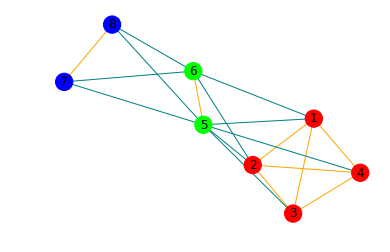

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import sys
sys.path.insert(0,'../')
from mvpose.candidates.transitivity import TransitivityLookup

# jid, id
D = [(0,0), (0,1),(0,2),(0,3),(1,0),(1,1),(2,0),(2,1)]

# jid1, jid2, a, b
E_l = [
    (0, 1, 0, 0),
    (0, 1, 0, 1),
    (0, 1, 1, 0),
    (0, 1, 1, 1),
    (0, 1, 2, 0),
    (0, 1, 3, 0),
    (1, 2, 0, 0),
    (1, 2, 0, 1),
    (1, 2, 1, 0),
    (1, 2, 1, 1)
]

# jid, a, b
E_j = [
    (0, 0, 1),
    (0, 0, 2),
    (0, 0, 3),
    (0, 1, 2),
    (0, 1, 3),
    (0, 2, 3),
    (1, 0, 1),
    (2, 0, 1)
] 
        
gr = TransitivityLookup(D, E_l, E_j)

#intra, inter = gr.query(1, 0)

q = (0, 0)
intra, inter = gr.query(*q)

Lkp = gr.lookup

print('query for ', Lkp[q])
print("==== INTRA ==== (" + str(len(intra)) + ")")
print([(Lkp[jid, a], Lkp[jid, b], Lkp[jid, c]) for jid, a, b, c in intra])

print("\n==== INTER ==== (" + str(len(inter)) + ")")
print([(Lkp[jid1, a], Lkp[jid1, b], Lkp[jid2, c]) \
         for jid1, a, b, jid2, c in inter])

plt.subplot(111)

gr.plot()

## Test CPLEX

Error reported Version number is 8.0, license is for version 7.0 - license file '/home/julian/gurobi.lic'
